# Series forecasting: Demanda de electricidad del estado de Victoria en Australia

**Objetivos:**

- Desarrollar y entrenar un modelo de pronóstico de demanda, utilizando datos históricos de un día completo como entrada, para generar predicciones con un horizonte de 24 horas en intervalos de 30 minutos.
- Evaluar el desempeño del modelo, calculando métricas de error como MAE, RMSE y MAPE, y visualizar los resultados de manera clara e interpretable.

### Importe de librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Cargue de información

In [2]:
df = pd.read_parquet("hf://datasets/rajistics/electricity_demand/data/train-00000-of-00001.parquet")

c:\Users\Usuario\anaconda3\envs\Pruebas_trabajos\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Conocer el tipo de dato y verificar que la columna de fecha tenga el formato correcto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Demand             1344 non-null   float64       
 1   Temperature        1344 non-null   float64       
 2   __index_level_0__  1344 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(2)
memory usage: 31.6 KB


In [4]:
# Renombrar la columna de fecha
df.rename(columns={'__index_level_0__': 'date'}, inplace=True)
df[:5]

,Demand,Temperature,date
0,3.794,18.05,2014-01-01 00:00:00
1,3.418,17.20,2014-01-01 01:00:00
2,3.152,16.45,2014-01-01 02:00:00
3,3.026,16.65,2014-01-01 03:00:00
4,3.022,16.40,2014-01-01 04:00:00


In [5]:
fecha_min = df['date'].min()
fecha_max = df['date'].max()

print(f"Fecha mínima: {fecha_min}")
print(f"Fecha máxima: {fecha_max}")

# Completitud
print(f'Datos necesarios: {len(pd.date_range(start=fecha_min, end=fecha_max, freq="H"))}')

Fecha mínima: 2014-01-01 00:00:00
Fecha máxima: 2014-02-25 23:00:00
Datos necesarios: 1344


In [6]:
df.isnull().sum()

Demand         0
Temperature    0
date           0
dtype: int64

**Comentarios**: El dataset está conformado por 2 variables numéricas (Demand y Temperature) y 1 variable de tipo datetime. Los registros fueron tomados horariamente desde el 01-01-2014 hasta el 25-02-2014 en el estado de Victoria - Australia. Al revisar los datos, se corrobora que están completos, por lo que el set de datos dispone de 1344 filas.

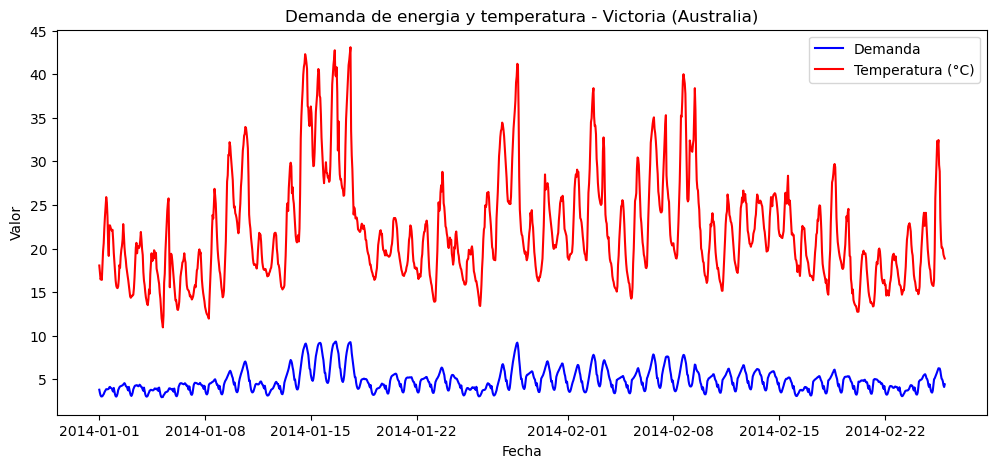

In [7]:
# Viualizar los datos originales
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['Demand'], label='Demanda', color='b')
plt.plot(df['date'], df['Temperature'], label='Temperatura (°C)', color='r')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Demanda de energia y temperatura - Victoria (Australia)')
plt.legend()
plt.show()

### Interpolación datos a 30 minutos

In [8]:
df.set_index('date', inplace=True)
df_resampled = df.copy()
df_resampled = df_resampled.resample('30T').interpolate(method='time')

### EDA: Análisis exploratorio de datos

In [9]:
def graficos_univariados(df):
    df = df.copy()
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    for i, column in enumerate(['Demand', 'Temperature']):
        # Gráfico de dispersión completo en la primera fila
        sns.scatterplot(x=df.index, y=df[column], ax=axs[0, i])
        axs[0, i].set_title(f'Dispersión de {column}')
        
        # Calcular los cuartiles
        Q1 = df[column].quantile(0.25)
        Q2 = df[column].quantile(0.50)
        Q3 = df[column].quantile(0.75)
        
        # Dibujar las líneas de los cuartiles
        axs[0, i].axhline(Q1, color='red', linestyle='--', label='Q1 (25%)')
        axs[0, i].axhline(Q2, color='green', linestyle='-', label='Q2 (50%)')
        axs[0, i].axhline(Q3, color='red', linestyle='--', label='Q3 (75%)')
        axs[0, i].legend(loc='upper right')
        
        # Histograma en la segunda fila
        sns.histplot(df[column], kde=True, ax=axs[1, i])
        axs[1, i].set_title(f'Histograma de {column}')
        
        # Dibujar las líneas de los cuartiles
        axs[1, i].axvline(Q1, color='red', linestyle='--', label='Q1 (25%)')
        axs[1, i].axvline(Q2, color='green', linestyle='-', label='Q2 (50%)')
        axs[1, i].axvline(Q3, color='red', linestyle='--', label='Q3 (75%)')
        axs[1, i].legend(loc='upper right')
        
        # Boxplot en la tercera fila
        sns.boxplot(y=df[column], ax=axs[2, i])
        axs[2, i].set_title(f'Boxplot de {column}')
    
    # Ajustar diseño
    plt.tight_layout()
    
    # Mostrar gráficos
    plt.show()


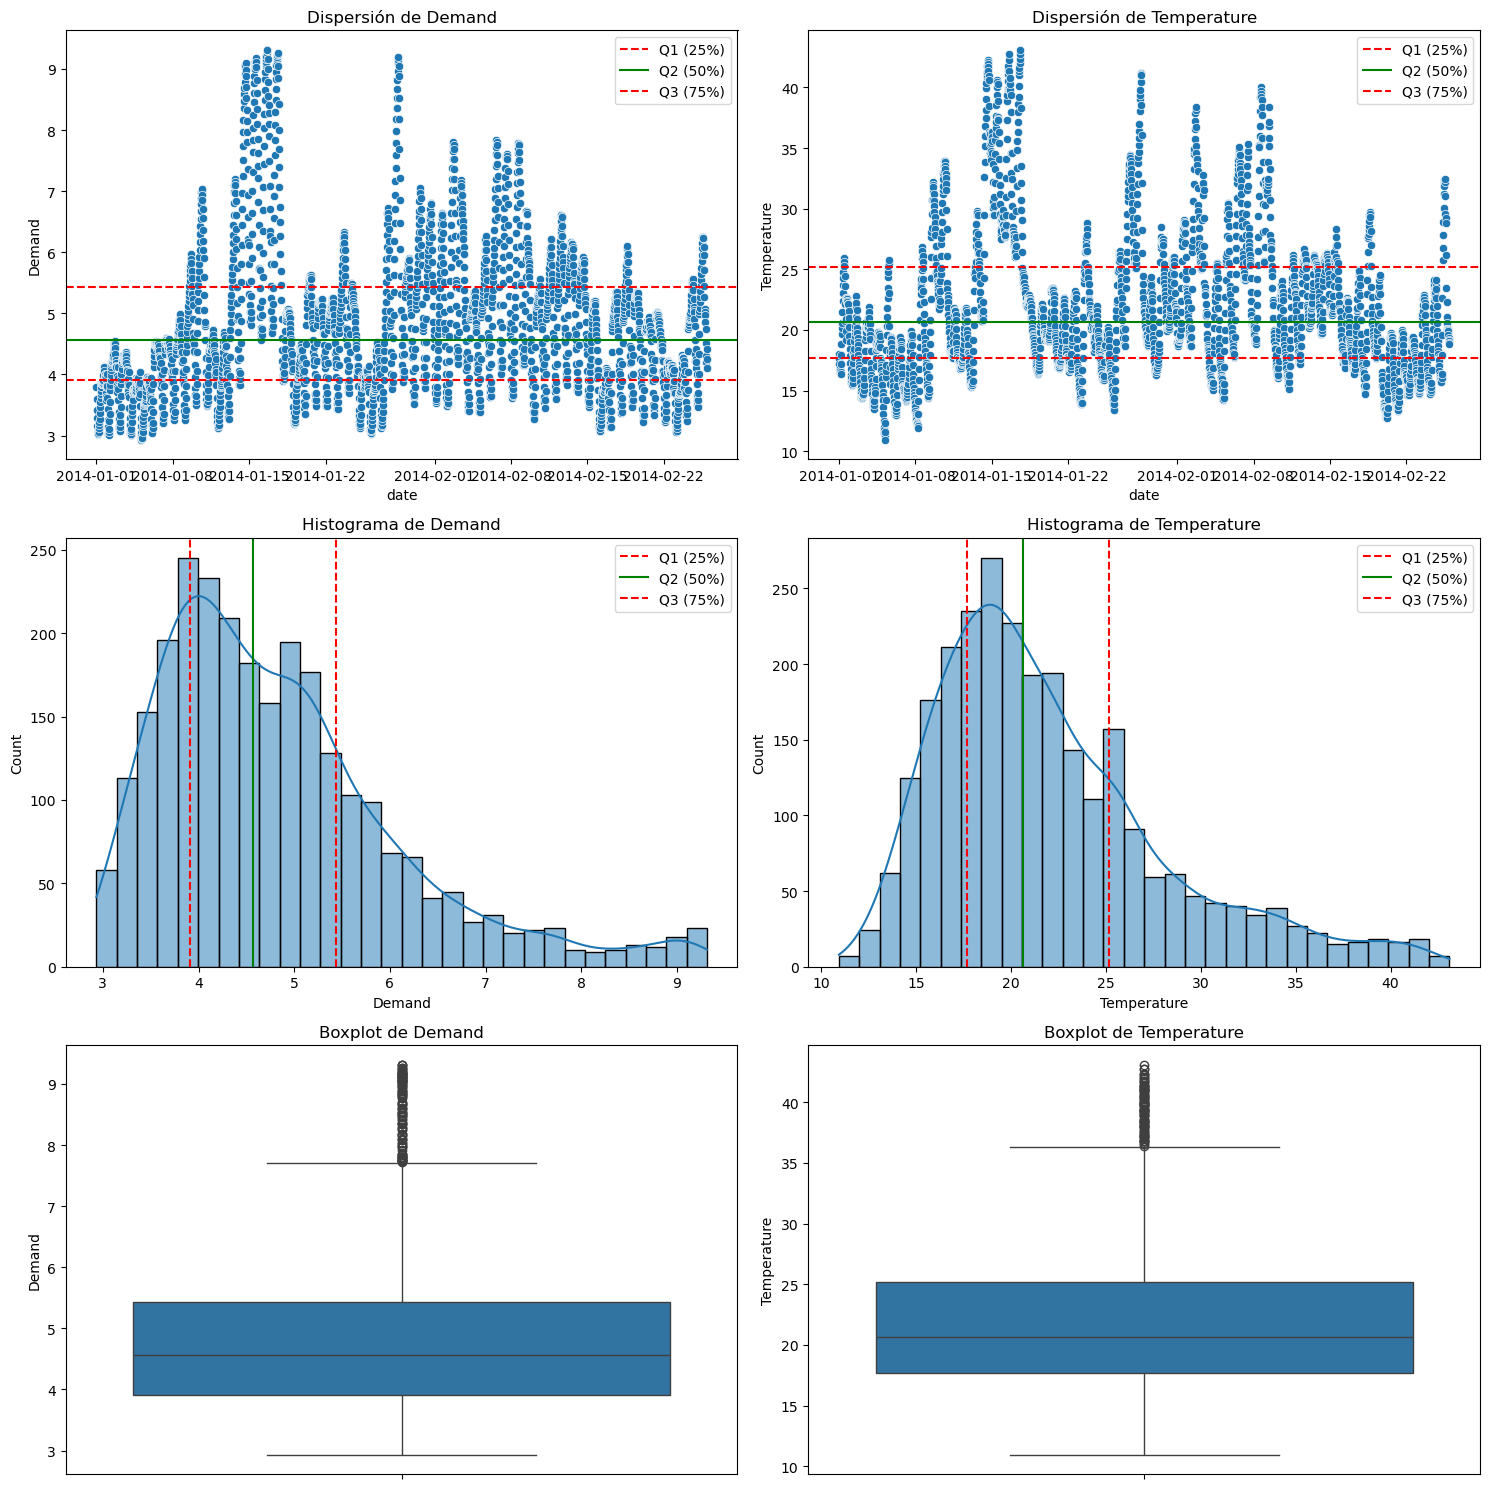

In [10]:
graficos_univariados(df_resampled)

In [11]:
df_resampled.describe()

,Demand,Temperature
count,2687.00000,2687.000000
mean,4.83714,22.033327
std,1.26585,6.071228
min,2.93300,10.950000
25%,3.90875,17.700000
50%,4.56400,20.625000
75%,5.43175,25.175000
max,9.31300,43.100000


In [12]:
# Función para calcular y mostrar sesgo y curtosis
def calcular_moments(df, column):
    skewness = skew(df[column])
    kurt = kurtosis(df[column]) + 3  # Convertir a curtosis de Fisher a Pearson
    print(f"{column}:\n  - Skewness: {skewness:.4f}\n  - Kurtosis: {kurt:.4f}\n")

# Calcular para ambas variables
calcular_moments(df_resampled, 'Demand')
calcular_moments(df_resampled, 'Temperature')

Demand:
  - Skewness: 1.2105
  - Kurtosis: 4.5262

Temperature:
  - Skewness: 1.0835
  - Kurtosis: 3.9470



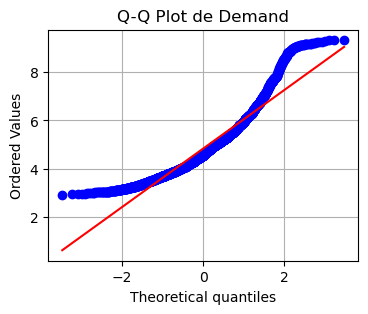

In [13]:
import scipy.stats as stats
def qq_plot(df, column):
    plt.figure(figsize=(4, 3))
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot de {column}')
    plt.grid()
    plt.show()

# Aplicar Q-Q plot a Demand y Temperature
qq_plot(df_resampled, 'Demand')

**Comentarios:** Ambas variables tienen valores similares de sesgo y curtosis, el sesgo mayor a 0 implica que las distribuciones tinen colas largas a la derecha, lo que se evidencia en sus histogramas. Respecto a la curtosis, ambos valores son mayores a 3, lo que indica la presencia de colas pesadas y potenciales valores atípicos.

Sin embargo, dado que tanto las variable de Demanda como de Temperatura presentan valores "atípicos" en los mismos intervalos de tiempo, ver gráficas de dispersión, se infiere que son valores reales (picos en la demanda) y no de errores o ruido, por un posible daño de medidores u otros factores.

Respecto al sesgo, la corrección de la asimetria es necesaria para modelos lineales, dado que estos modelos asumen que las variables siguen distribuciones normales o simétricas, pero para otros tipos de modelos como Random Forest, o LSTM no se requiere dicha corrección. Para evaluar la normalidad, se utilizó el diagrama Q-Q plot, y no el test de Shapiro-Wilk ya que este test es sensible a muestras grandes (>5000) y tiende a rechazar la normalidad, a pesar de ello, con el diagrama también se obtiene que no se cumple con el criterio de normalidad, lo que refuerza lo previamente expuesto.

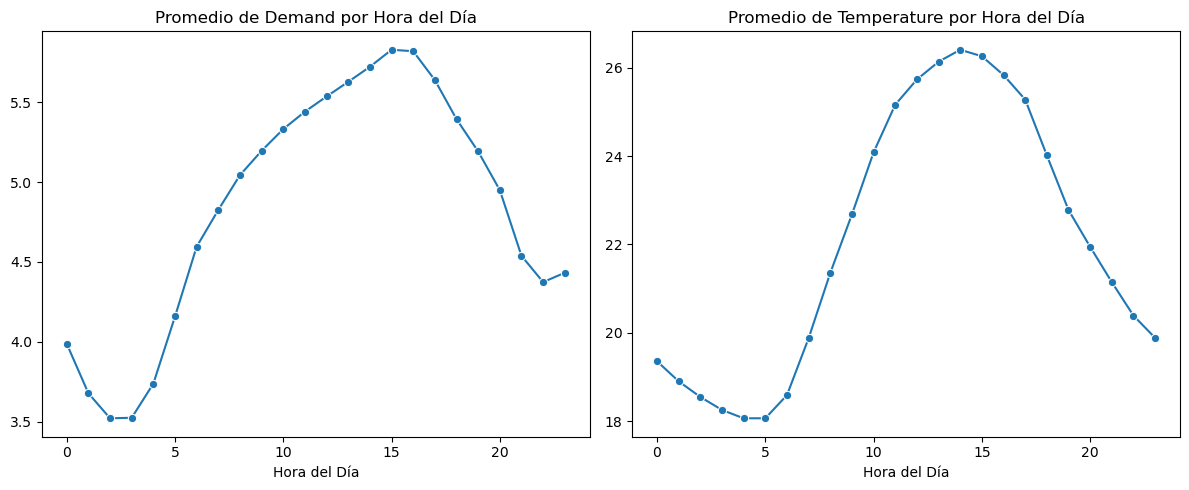

In [14]:
def grafico_por_hora(df):
    df = df.copy()
       
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    for i, column in enumerate(['Demand', 'Temperature']):
        df_por_hora = df.groupby(df.index.hour)[column].mean()
        sns.lineplot(x=df_por_hora.index, y=df_por_hora.values, ax=axs[i], marker='o')
        axs[i].set_title(f'Promedio de {column} por Hora del Día')
        axs[i].set_xlabel('Hora del Día')
    
    plt.tight_layout()
    plt.show()

grafico_por_hora(df_resampled)

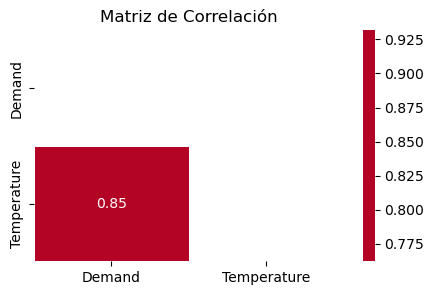

In [15]:
# Calcula la matriz de correlación
correlation_matrix = df_resampled[['Demand', 'Temperature']].corr()

# Crear una máscara para la parte superior derecha de la matriz
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualiza la matriz de correlación con un corrplot (heatmap)
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

El coeficiente de correlación entre Temperature y Demand es de 0,85 lo que implica que hay una correlación lineal significativa entre ambas variables. Por lo que se procede a calcular el VIF para evaluar si hay multicolinealidad.

In [16]:
# Calculo de VIF
numeric_features = df_resampled.select_dtypes(include=[np.number])  # Solo variables numéricas
X = numeric_features.values  # Convertir a matriz NumPy

# Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_features.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print(vif_data)

      Variable        VIF
0       Demand  48.456859
1  Temperature  48.456859


Un VIF (Variance Inflation Factor) de 48.46 indica una multicolinealidad extremadamente alta, lo que sugiere que la variable Temperature está fuertemente correlacionada con la variable Demand (Variable objetivo), por lo que para modelos como regresión y ARIMA, se opta por no utilizar la variable de temperatura.

Y si se desea tener en cuenta la temperatura, se pretende realizar posteriormente Feature Engineering, o transformación de variables aplicando diferencias o PCA para reducir la multicolinealidad.

Para saber cuál es el modelo mas adecuado para los datos, a continuación se hace un análisis de las características de la serie de tiempo como estacionalidad, tendencia, linealidad y ruido.

#### Análisis de la variable objetivo

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

def descomposition(df, column, freq=48):  # freq=48 para datos cada 30 min en un día
    # Descomposición de la serie de tiempo
    # decomposition = seasonal_decompose(df[column], period=freq, model='additive')
    decomposition = seasonal_decompose(df[column], period=freq, model='multiplicative')
    
    # Gráficos
    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(df[column], label='Original', color='black')
    plt.title(f'Serie de tiempo: {column}')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Tendencia', color='blue')
    plt.title('Tendencia')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Estacionalidad', color='green')
    plt.title('Estacionalidad')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuo (ruido)', color='red')
    plt.title('Residuo')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Medidas estadísticas
    trend_strength = 1 - np.var(decomposition.resid.dropna()) / np.var(decomposition.trend.dropna()) if np.var(decomposition.trend.dropna()) > 0 else 0
    seasonality_strength = 1 - np.var(decomposition.resid.dropna()) / np.var(decomposition.seasonal.dropna()) if np.var(decomposition.seasonal.dropna()) > 0 else 0
    linear_model = sm.OLS(df[column].dropna(), sm.add_constant(np.arange(len(df[column].dropna())))).fit()
    
    print(f"**Fuerza de tendencia:** {trend_strength:.4f}")
    print(f"**Fuerza de estacionalidad:** {seasonality_strength:.4f}")
    print(f"**R² de linealidad:** {linear_model.rsquared:.4f}")

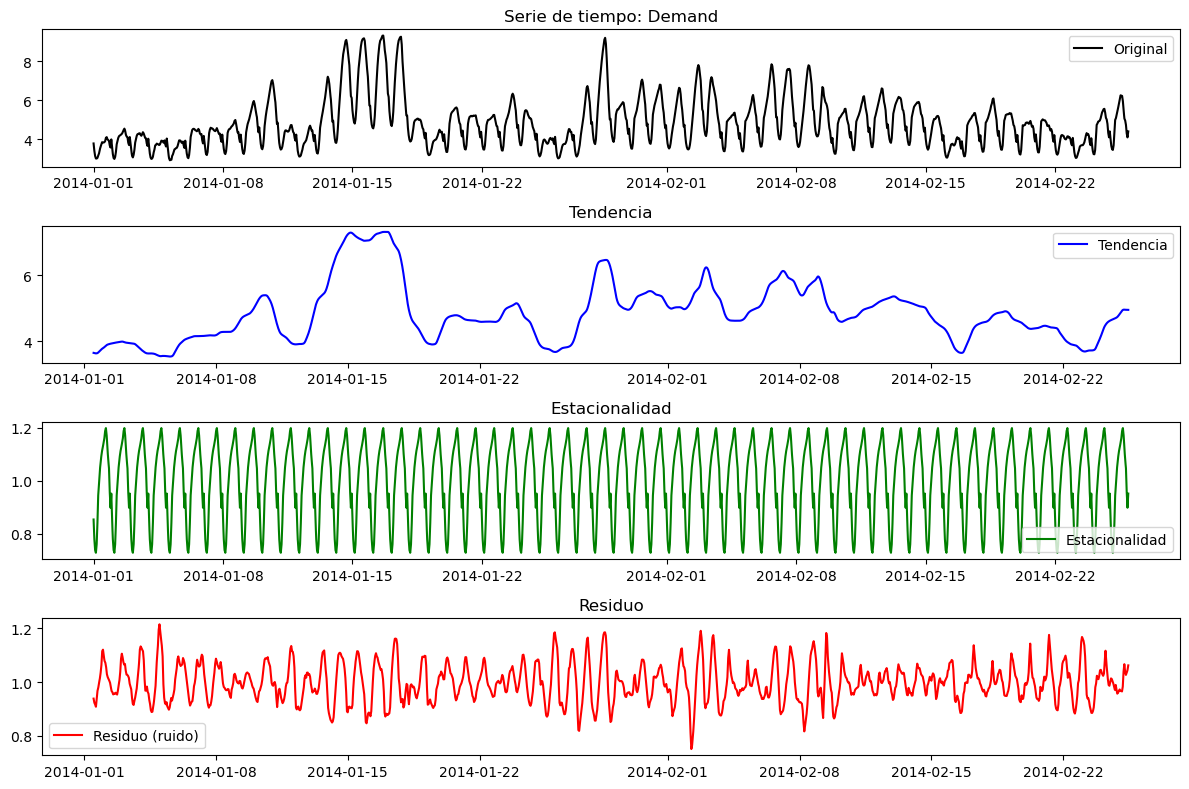

**Fuerza de tendencia:** 0.9937
**Fuerza de estacionalidad:** 0.7759
**R² de linealidad:** 0.0018


In [18]:
descomposition(df_resampled, 'Demand', freq=48)

**Comentarios**: Se descompone la serie de tiempo de la variable Demanda para definir que tipo de modelos pueden ser más adecuados, se probó tanto la descomposición de tipo aditivo como multiplicativo. Teniendo en cuenta los resultados y la serie de tiempo, se define que el multiplicativo explica mejor el comportamiento.

Con lo anterior, se tiene que, la serie tiene una tendencia muy fuerte así como un componente estacional significativo, por lo que se podrian tener en cuenta modelos como SARIMA o LSTM con embedding de tiempo. La baja linealidad indica que los modelos lineales no son tan adecuados en este caso, por lo que no se hará la transformación para la normalidad.

Se procede a hacer test de estaciona

# Prueba estacionalid

#### División en dataset de entrenamiento y prueba

In [19]:
# Dividir en train y test (último 20% para test)
train_size = int(len(df_resampled) * 0.8)
train = df_resampled.iloc[:train_size]
test = df_resampled.iloc[train_size:]

In [ ]:
# import itertools

# # Definir posibles valores para los hiperparámetros
# p = d = q = range(0, 3)  # Para ARIMA
# P = D = Q = range(0, 2)  # Para la parte estacional
# s = [24, 48]  # Período estacionalidad (cambia según la serie)

# # Generar combinaciones de parámetros
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(P, D, Q, s))

# # Probar cada combinación y almacenar resultados
# best_aic = np.inf
# best_params = None

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         try:
#             modelo = SARIMAX(train['Demand'], 
#                              order=param, 
#                              seasonal_order=seasonal_param,
#                              enforce_stationarity=False, 
#                              enforce_invertibility=False)
#             resultado = modelo.fit()
#             if resultado.aic < best_aic:
#                 best_aic = resultado.aic
#                 best_params = (param, seasonal_param)
#             print(f'Probando {param} {seasonal_param} - AIC: {resultado.aic}')
#         except:
#             continue

# print(f'\nMejor combinación encontrada: {best_params} con AIC: {best_aic}')

MAE: 0.57
RMSE: 0.79
MAPE: 13.57%


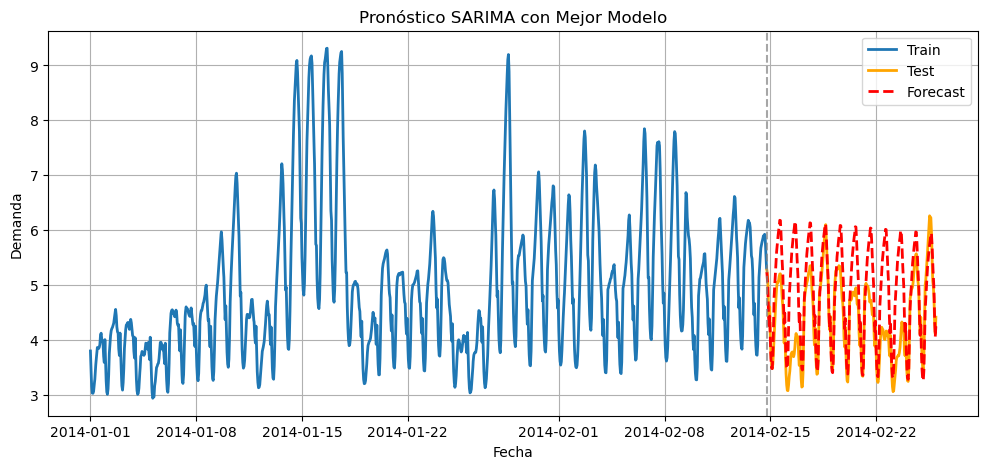

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

# Definir la serie temporal
y = train['Demand']

# Usar la mejor combinación encontrada manualmente
p, d, q = (1, 1, 2)
P, D, Q, s = (1, 0, 1, 48)

# Definir y entrenar el modelo SARIMA con los parámetros óptimos
modelo = SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                 enforce_stationarity=False, enforce_invertibility=False)

resultado = modelo.fit()

# Predicción para el conjunto de prueba
predicciones = resultado.forecast(steps=len(test))

# Evaluación del modelo con manejo de valores nulos o infinitos
predicciones = np.nan_to_num(predicciones, nan=np.mean(y))
mae = mean_absolute_error(test['Demand'], predicciones)
rmse = np.sqrt(mean_squared_error(test['Demand'], predicciones))
mape = np.mean(np.abs((test['Demand'] - predicciones) / test['Demand'])) * 100

# Mostrar métricas
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Graficar resultados
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Demand'], label='Train', linewidth=2)
plt.plot(test.index, test['Demand'], label='Test', color='orange', linewidth=2)
plt.plot(test.index, predicciones, label='Forecast', color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=test.index[0], color='gray', linestyle='--', alpha=0.7)  # Línea divisoria entre train y test
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Pronóstico SARIMA con Mejor Modelo')
plt.grid(True)
plt.show()

MAE: 0.05
RMSE: 0.06
MAPE: 1.14%


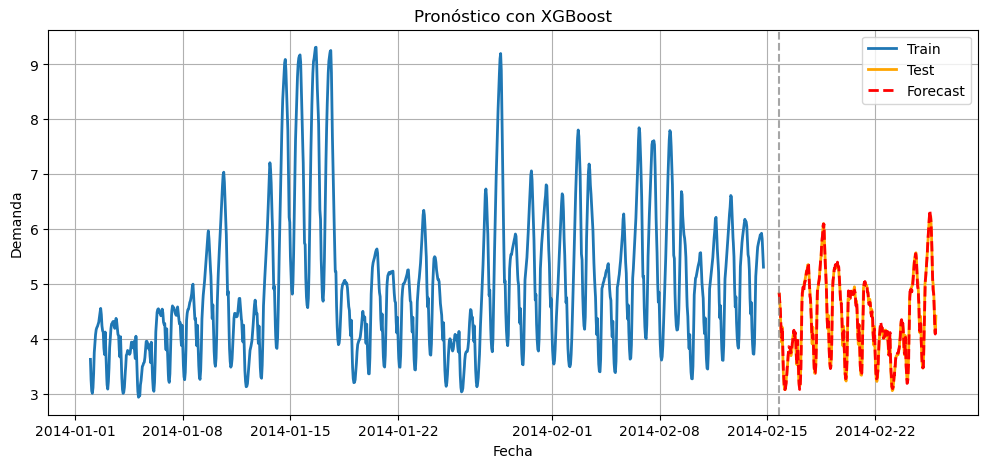

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Creación de características de retraso para series temporales
def create_lag_features(data, lags=48):
    df_lag = data.copy()
    for lag in range(1, lags + 1):
        df_lag[f'lag_{lag}'] = df_lag['Demand'].shift(lag)
    return df_lag.dropna()

train_lagged = create_lag_features(train)
test_lagged = create_lag_features(test)

X_train, y_train = train_lagged.drop(columns=['Demand']), train_lagged['Demand']
X_test, y_test = test_lagged.drop(columns=['Demand']), test_lagged['Demand']

# Definir y entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Predicción para el conjunto de prueba
predicciones = model.predict(X_test)

# Evaluación del modelo
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
mape = np.mean(np.abs((y_test - predicciones) / y_test)) * 100

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

# Graficar resultados con toda la serie de tiempo
plt.figure(figsize=(12, 5))
plt.plot(train_lagged.index, train_lagged['Demand'], label='Train', linewidth=2)
plt.plot(test_lagged.index, test_lagged['Demand'], label='Test', color='orange', linewidth=2)
plt.plot(test_lagged.index, predicciones, label='Forecast', color='red', linestyle='dashed', linewidth=2)
plt.axvline(x=test_lagged.index[0], color='gray', linestyle='--', alpha=0.7)  # Línea divisoria entre train y test
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Pronóstico con XGBoost')
plt.grid(True)
plt.show()
